In [5]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import scipy.io
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns



In [6]:
action_names = ['Swipe left','Swipe right','Wave','Clap','Throw','Arm cross','Basketball shoot',
                'Draw X','Draw circle (clockwise)','Draw circle (counter clockwise)','Draw triangle',
                'Bowling','Boxing','Baseball swing','Tennis swing','Arm curl','Tennis serve','Push',
                'Knock','Catch','Pickup and throw','Jog','Walk','Sit to stand','Stand to sit','Lunge','Squat']
names = [0.2, 0.4, 0.6000000000000001, 0.8]

In [7]:
def plot_3D_skeleton(skeleton,ax):
    ''' This function defines the bone list and plot the skeleton from given cordinates'''

#     bone_list = [[0,1],[1,2], [2, 3], [2, 4], [4, 5], [5, 6], [6,7],[2, 8], [8,9], [9,10], [10, 11], 
#             [0,12],[12,13],[13, 14], [14, 15],[0,16],[16, 17], [17,18], [18, 19], [7, 21],[7,22],[11,23],[11,24]]#, [11, 22], [12, 13], ,[22,23],[23,24],[24,25]]
    bone_list = [[0,1],[1,2], [2, 3], [1, 4], [4, 5], [5, 6], [6,7],[1, 8], [8,9], [9,10], [10, 11], 
            [3,12],[12,13],[13, 14], [14, 15],[3,16],[16, 17], [17,18], [18, 19]]#, [11, 22], [12, 13], ,[22,23],[23,24],[24,25]]

    x = skeleton[:, 0]
    z = skeleton[:, 1]
    y = skeleton[:, 2]
    sc = ax.scatter(x, y, z, s=20)
    for bone in bone_list:
        ax.plot([x[bone[0]], x[bone[1]]], [y[bone[0]], y[bone[1]]], [z[bone[0]], z[bone[1]]], 'b')

In [8]:
def interpolate_cols(d_iner,interpval=60):
    # Intialise empty matrix
    imat = np.zeros((interpval,d_iner.shape[1]))
    for i in range(d_iner.shape[1]):
        val = d_iner[:,i]
        ival = interp_vals(val,interpval)
        
        # normalise values between 0-1
        ival = norm_vals(ival)
        
        # Store values back to matrix
        imat[:,i] = ival
    return imat

In [9]:
def interp_vals(yin,numFrames):
    ''' This function interpolate Values of sensor according to number of frames'''
    xin = np.linspace(0, numFrames, len(yin))
    xnew = np.arange(0, numFrames)
    ynew = np.interp(xnew, xin, yin)
    return ynew

In [10]:
def norm_vals(x):
    '''Function to normalise any values between 0 to 1'''
    x = x-np.min(x)
    x = x/np.max(x)
    return x

In [11]:
def average_frame(D):
    D1 = D.max(axis=2)
    D2 = D.min(axis=2)
    Dmid = D1+D2
    # Option 2 is averaging all values which is not so effective.
    #     Dmid = np.mean(D,axis=2)
    # Normalise between 0 - 1
    Dmid = Dmid/np.max(Dmid)
    return Dmid

In [12]:
def extract_features(S,flength,spoints):
    ''' This function takes x,y and z cordinate of specified skeleton joint and interpolate all values to given flength, 
    Finally normalise all values between 0-1 and return it as feature matrix'''
    feature_matrix = np.zeros((len(spoints)*3,flength))
    for i in range(len(spoints)):
        # Get X values for all frames
        sx = S[spoints[i],0,:]

        # Get Y values for all frames
        sy = S[spoints[i],1,:]

        # Get Z values for all frames
        sz = S[spoints[i],2,:]

        # Interpolate values
        sxi = interp_vals(sx,flength)
        syi = interp_vals(sy,flength)
        szi = interp_vals(sz,flength)

        # Normalise values
        sxi = norm_vals(sxi)
        syi = norm_vals(syi)
        szi = norm_vals(szi)
        
        # Store values into feature matrix
        feature_matrix[i*3,:] = sxi
        feature_matrix[i*3+1,:] = syi
        feature_matrix[i*3+2,:] = szi    
        
    return feature_matrix

In [13]:
from tensorflow.keras.models import model_from_json
def load_model(filename):
    #  load json and create model
    json_file = open(filename+ ".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(filename+".h5")
    return loaded_model

In [14]:
aID = 1
sID=1
tID =1

In [15]:
from IPython.display import display
def on_button_clicked(b):
    global aID,sID,tID
    global numFrames,D,S,d_iner
    # Create path for all 
    path = './{0}/a{1}_s{2}_t{3}_{4}.mat'
    
    # Create paths for Depth, Skeleton and Inertial Sensor files
    Dpath = path.format('depth',aID,sID,tID,'depth')
    Spath = path.format('skeleton',aID,sID,tID,'skeleton')
    Ipath = path.format('inertial',aID,sID,tID,'inertial')
    # ------ Read Depth ---------
    # read .MAT file for Dpath
    matD = scipy.io.loadmat(Dpath)

    # Obtain d_depth from matD dictionary.
    D = matD['d_depth']

    # Get number of frames based on 3rd dimension of matrix
    numFrames = D.shape[-1]

    # ---------- Skeleton -------------
    # read .MAT file for Skeleton
    matS = scipy.io.loadmat(Spath)

    # GEt skeleton data from dictionary
    S = matS['d_skel']
    # Get number of frames based on 3rd dimension of matrix
    numFrames =S.shape[-1]

    # --------- Sensor ------------------
    # Inertial
    mat_inn = scipy.io.loadmat(Ipath)
    # Get sensor value
    d_iner = mat_inn['d_iner']
    # interpolate and normalise all columns
    fi = interpolate_cols(d_iner,numFrames)
    
 
    # axbig2 = fig.add_subplot(gs[2,:])
    for i in range(40):
        ax3D.clear()
        axbig.clear()
        axbig2.clear()
        axim.clear()
        axim.imshow(D[:,:,i])
        axim.set_title(('Frame-' , i))
        skeleton = S[:,:,i] 
        ax3D.scatter([-0.5, 0.5],[1,4],[-0.5,0.5],alpha = 0)
        plot_3D_skeleton(skeleton,ax3D)
        axbig.plot(fi[:i,0],label="X_acc")
        axbig.plot(fi[:i,1],label="Y_acc")
        axbig.plot(fi[:i,2],label="Z_acc")
        axbig.legend(loc='lower left')       
        axbig2.plot(fi[:i,3],label="X_avl")
        axbig2.plot(fi[:i,4],label="Y_avl")
        axbig2.plot(fi[:i,5],label="Z_avl")
        axbig2.legend(loc='lower left')
#         plt.show()
        fig.canvas.draw()
    
    ax3D.mouse_init()
    
button = widgets.Button(description="Load Data")
button.on_click(on_button_clicked)

In [16]:
def FE_clicked(b):
    global aID,sID,tID
    global numFrames,D,S,d_iner
    global Dmid, fm, fi
    # Create path for all 
    path = './{0}/a{1}_s{2}_t{3}_{4}.mat'
    
    # Create paths for Depth, Skeleton and Inertial Sensor files
    Dpath = path.format('depth',aID,sID,tID,'depth')
    Spath = path.format('skeleton',aID,sID,tID,'skeleton')
    Ipath = path.format('inertial',aID,sID,tID,'inertial')
    # ------ Read Depth ---------
    # read .MAT file for Dpath
    matD = scipy.io.loadmat(Dpath)

    # Obtain d_depth from matD dictionary.
    D = matD['d_depth']

    # Get number of frames based on 3rd dimension of matrix
    numFrames = D.shape[-1]
   
    # ---------- Skeleton -------------
    # read .MAT file for Skeleton
    matS = scipy.io.loadmat(Spath)

    # GEt skeleton data from dictionary
    S = matS['d_skel']
    # Get number of frames based on 3rd dimension of matrix
    numFrames =S.shape[-1]

    # --------- Sensor ------------------
    # Inertial
    mat_inn = scipy.io.loadmat(Ipath)
    # Get sensor value
    d_iner = mat_inn['d_iner']
   
    # ------------ Feature Extraction ----------------------
    # Define feature length
    flength = 60
    # Skeleton points to be considered for features
    spoints = [1,11,7,8,4,15,19,3]

    # Call feature extractor function
    Dmid = average_frame(D)

    # plt.imshow(Dmid)

    # Call function to extract feature matrix
    fm = extract_features(S,flength,spoints)

    # # show image
    # plt.imshow(fm)
    # interpolate and normalise all columns
    fi = interpolate_cols(d_iner,flength)

    
    axfe[0].imshow(Dmid)
    axfe[0].set_title('Depth features')
    axfe[1].imshow(fm)
    axfe[1].set_title('Skeleton features')
    axfe[2].imshow(fi)
    axfe[2].set_title('sensor features')
    
buttonfe = widgets.Button(description="Feature Extraction")
buttonfe.on_click(FE_clicked)

In [17]:
def pred_clicked(b):
    global action_names
    global aID,sID,tID
    global numFrames,D,S,d_iner
    global Dmid, fm, fi
    global Dmodel, Smodel, Imodel
    global op1, op2, op3,op4
    # Create path for all 
    path = './{0}/a{1}_s{2}_t{3}_{4}.mat'
    
    # Create paths for Depth, Skeleton and Inertial Sensor files
    Dpath = path.format('depth',aID,sID,tID,'depth')
    Spath = path.format('skeleton',aID,sID,tID,'skeleton')
    Ipath = path.format('inertial',aID,sID,tID,'inertial')
    # ------ Read Depth ---------
    # read .MAT file for Dpath
    matD = scipy.io.loadmat(Dpath)

    # Obtain d_depth from matD dictionary.
    D = matD['d_depth']

    # Get number of frames based on 3rd dimension of matrix
    numFrames = D.shape[-1]
   
    # ---------- Skeleton -------------
    # read .MAT file for Skeleton
    matS = scipy.io.loadmat(Spath)

    # GEt skeleton data from dictionary
    S = matS['d_skel']
    # Get number of frames based on 3rd dimension of matrix
    numFrames =S.shape[-1]

    # --------- Sensor ------------------
    # Inertial
    mat_inn = scipy.io.loadmat(Ipath)
    # Get sensor value
    d_iner = mat_inn['d_iner']
   
    # ------------ Feature Extraction ----------------------
    # Define feature length
    flength = 60
    # Skeleton points to be considered for features
    spoints = [1,11,7,8,4,15,19,3]

    # Call feature extractor function
    Dmid = average_frame(D)

    # plt.imshow(Dmid)

    # Call function to extract feature matrix
    fm = extract_features(S,flength,spoints)

    # # show image
    # plt.imshow(fm)
    # interpolate and normalise all columns
    fi = interpolate_cols(d_iner,flength)

    # Initialise empty matrix
    imf = np.zeros((200,200))
    Sf = np.zeros((len(spoints)*3,flength))
    If = np.zeros((flength,6))

    # Store features to empty matrix
    Sf = np.dstack((Sf,fm))
    Dcrop = Dmid[40:,50:250]
    imf = np.dstack((imf,Dcrop))
    If = np.dstack((If,fi))

    # change the dimention of features as per model's input dimension
    S_norm=np.rollaxis(Sf,2,0)
    D_norm=np.rollaxis(imf,2,0)
    I_norm = np.rollaxis(If,2,0)

    # Recognition
    # Evaluate all three models
    Dpred = Dmodel.predict(D_norm)
    Spred = Smodel.predict(S_norm)
    Ipred = Imodel.predict(I_norm)

    # Create fusion result
    Fpred = (Dpred+Spred+Ipred)/3

    resmat = np.zeros((27,4))
    resmat[:,0] = Dpred[1]
    resmat[:,1] = Spred[1]
    resmat[:,2] = Ipred[1]
    resmat[:,3] = Fpred[1]
    Dop = np.argmax(Dpred[1])
    Sop = np.argmax(Spred[1])
    Iop = np.argmax(Ipred[1])
    Fop = np.argmax(Fpred[1])
    
    op1.value = "Depth :" + action_names[Dop]
    op2.value = "Skeleton :" + action_names[Sop]
    op3.value = "Sensor :" + action_names[Iop]
    op4.value = "Fusion :" + action_names[Fop]

    recdf = pd.DataFrame(resmat,columns=['Depth','Skeleton','Sensor','Fusion'])
    axpre.clear()
    recdf.plot(kind='barh',width = 0.8,ax=axpre)
    plt.xlabel('Probabiility score',fontsize=15)
    plt.yticks(ticks=range(0,27),labels=action_names,fontsize=16)
    plt.title('Probability',fontsize = 15)
    # Despine
    axpre.spines['right'].set_visible(False)
    axpre.spines['top'].set_visible(False)
    axpre.spines['left'].set_visible(False)
    axpre.spines['bottom'].set_visible(False)

    # Draw vertical axis lines
    vals = axpre.get_xticks()
    for tick in vals:
        axpre.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Set x-axis label
    axpre.set_xlabel("Average Trip Duration (Seconds)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    axpre.set_ylabel("Start Station", labelpad=20, weight='bold', size=12)
    
buttonpred = widgets.Button(description="Predict")
buttonpred.on_click(pred_clicked)

In [18]:
action = widgets.Dropdown(
    options=action_names,
    value='Swipe left',
    description='Action Name:',
)
subject = widgets.Dropdown(
    options=['Subject 1','Subject 2','Subject 3','Subject 4','Subject 5','Subject 6','Subject 7','Subject 8'],
    value='Subject 1',
    description='Subject:',
)
sample = widgets.Dropdown(
    options=['Sample 1','Sample 2','Sample 3','Sample 4'],
    value='Sample 1',
    description='Sample :',
)
def action_change(change):
    global aID
    if change['type'] == 'change' and change['name'] == 'index':
        aID = change['new']+1
def subject_change(change):
    global sID
    if change['type'] == 'change' and change['name'] == 'index':
        sID = change['new']+1
def sample_change(change):
    global tID
    if change['type'] == 'change' and change['name'] == 'index':
        tID = change['new']+1

action.observe(action_change)
subject.observe(subject_change)
sample.observe(sample_change)

In [19]:
Tsize = names[0]
str = '{0}model{1}'
Dmodel = load_model(str.format('D',Tsize))
Smodel = load_model(str.format('S',Tsize))
Imodel = load_model(str.format('I',Tsize))
toggle = widgets.ToggleButtons(
    options=['20 %', '40 %', '60 %','80 %'],
    description='Train Ratio:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Model Trained with 20% data','Model Trained with 40% data','Model Trained with 60% data','Model Trained with 80% data'],
#     icons=['check'] * 3
)
toggle

def on_click(change):
    global names
    global Dmodel, Smodel, Imodel
    print(change['new'])
    if change['new'] == '20 %':
        Tsize = names[0]
        Dmodel = load_model(str.format('D',Tsize))
        Smodel = load_model(str.format('S',Tsize))
        Imodel = load_model(str.format('I',Tsize))
        print('Loding complete')
    elif change['new'] == '40 %':
        Tsize = names[1]
        Dmodel = load_model(str.format('D',Tsize))
        Smodel = load_model(str.format('S',Tsize))
        Imodel = load_model(str.format('I',Tsize))
        print('Loding complete')
    elif change['new'] == '60 %':
        Tsize = names[2]
        Dmodel = load_model(str.format('D',Tsize))
        Smodel = load_model(str.format('S',Tsize))
        Imodel = load_model(str.format('I',Tsize))
        print('Loding complete')
    else:
        Tsize = names[3]
        Dmodel = load_model(str.format('D',Tsize))
        Smodel = load_model(str.format('S',Tsize))
        Imodel = load_model(str.format('I',Tsize))
        print('Loding complete')

toggle.observe(on_click, 'value')

In [20]:
op1 = widgets.Text(value='Depth',disabled=False)
op2 = widgets.Text(value='Skeleton',disabled=False)
op3 = widgets.Text(value='Sensor',disabled=False)
op4 = widgets.Text(value='Fusion',disabled=False)

Dropdown(description='Action Name:', options=('Swipe left', 'Swipe right', 'Wave', 'Clap', 'Throw', 'Arm cross…

Dropdown(description='Subject:', options=('Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Su…

Dropdown(description='Sample :', options=('Sample 1', 'Sample 2', 'Sample 3', 'Sample 4'), value='Sample 1')

Button(description='Load Data', style=ButtonStyle())

<IPython.core.display.Javascript object>


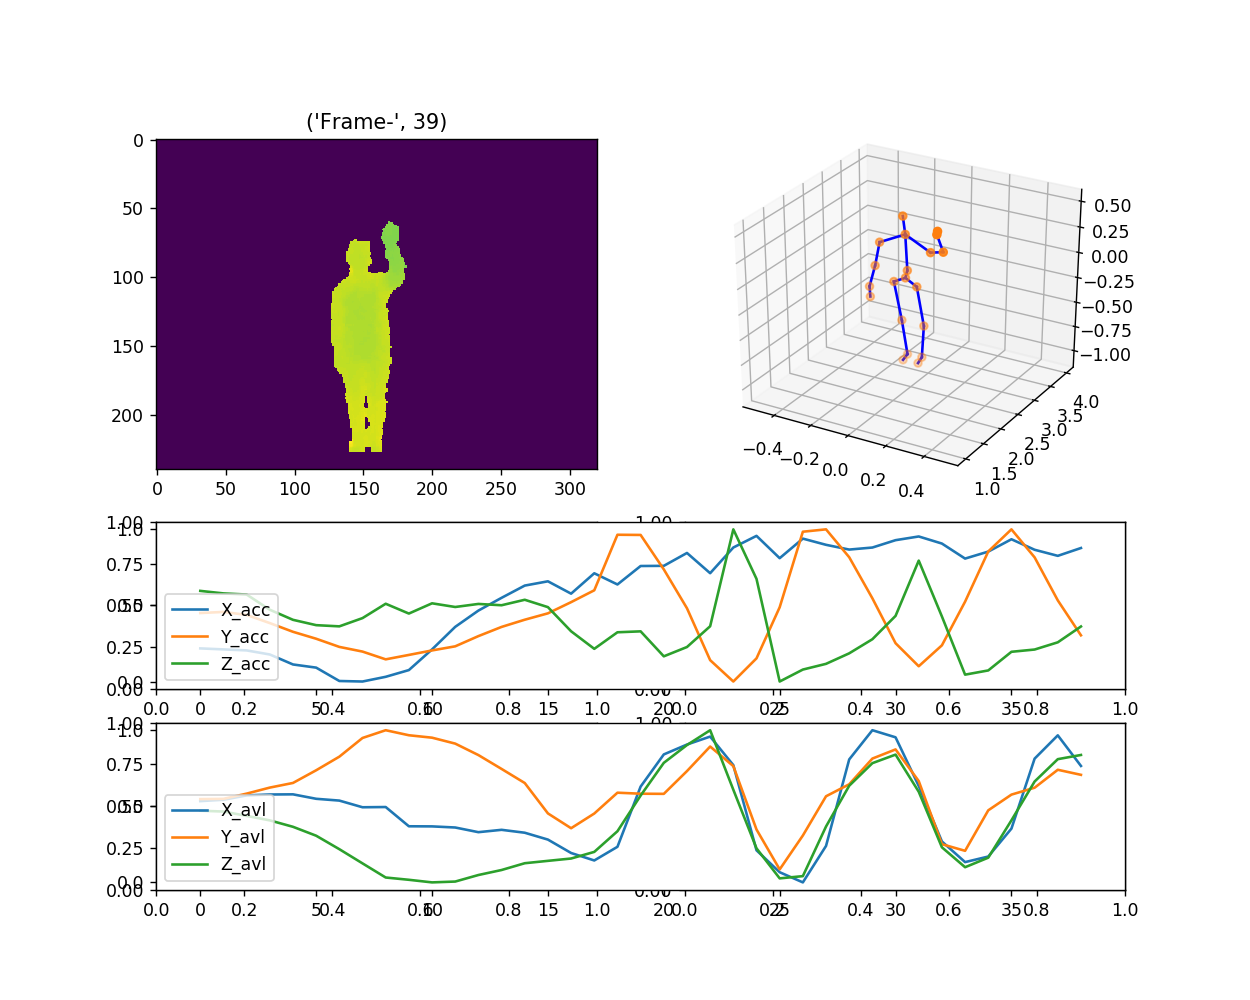

Button(description='Feature Extraction', style=ButtonStyle())

<IPython.core.display.Javascript object>


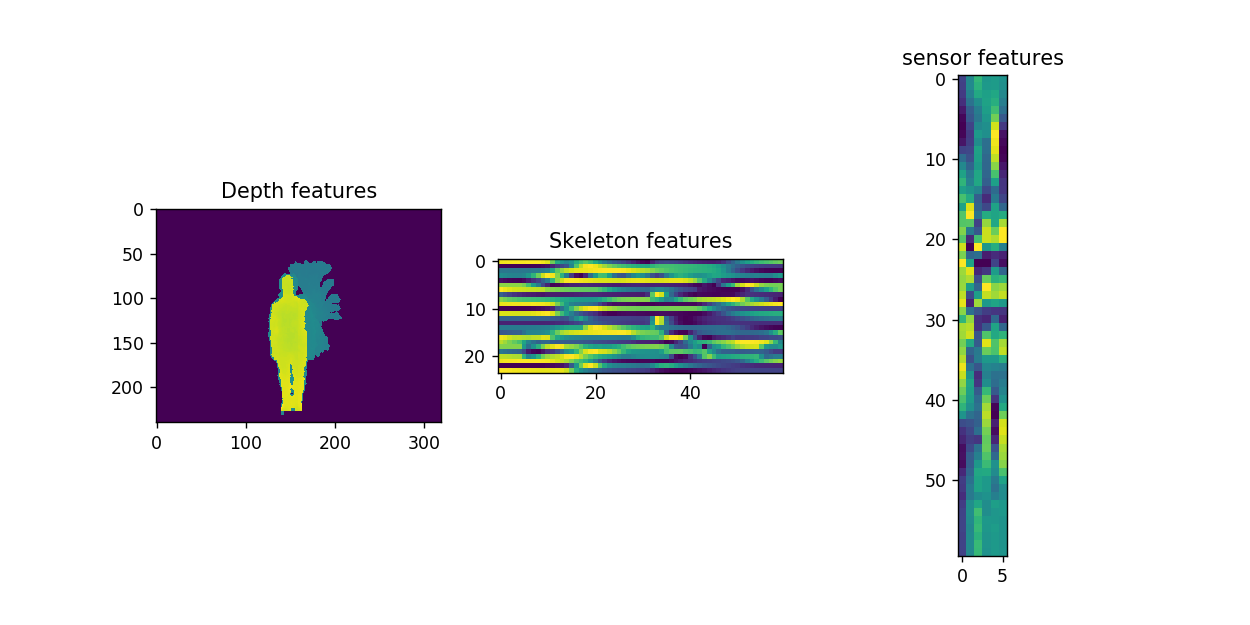

..............................
Load Model


ToggleButtons(description='Train Ratio:', options=('20 %', '40 %', '60 %', '80 %'), tooltips=('Model Trained w…

Button(description='Predict', style=ButtonStyle())

Text(value='Depth')

Text(value='Skeleton')

Text(value='Sensor')

Text(value='Fusion')

<IPython.core.display.Javascript object>


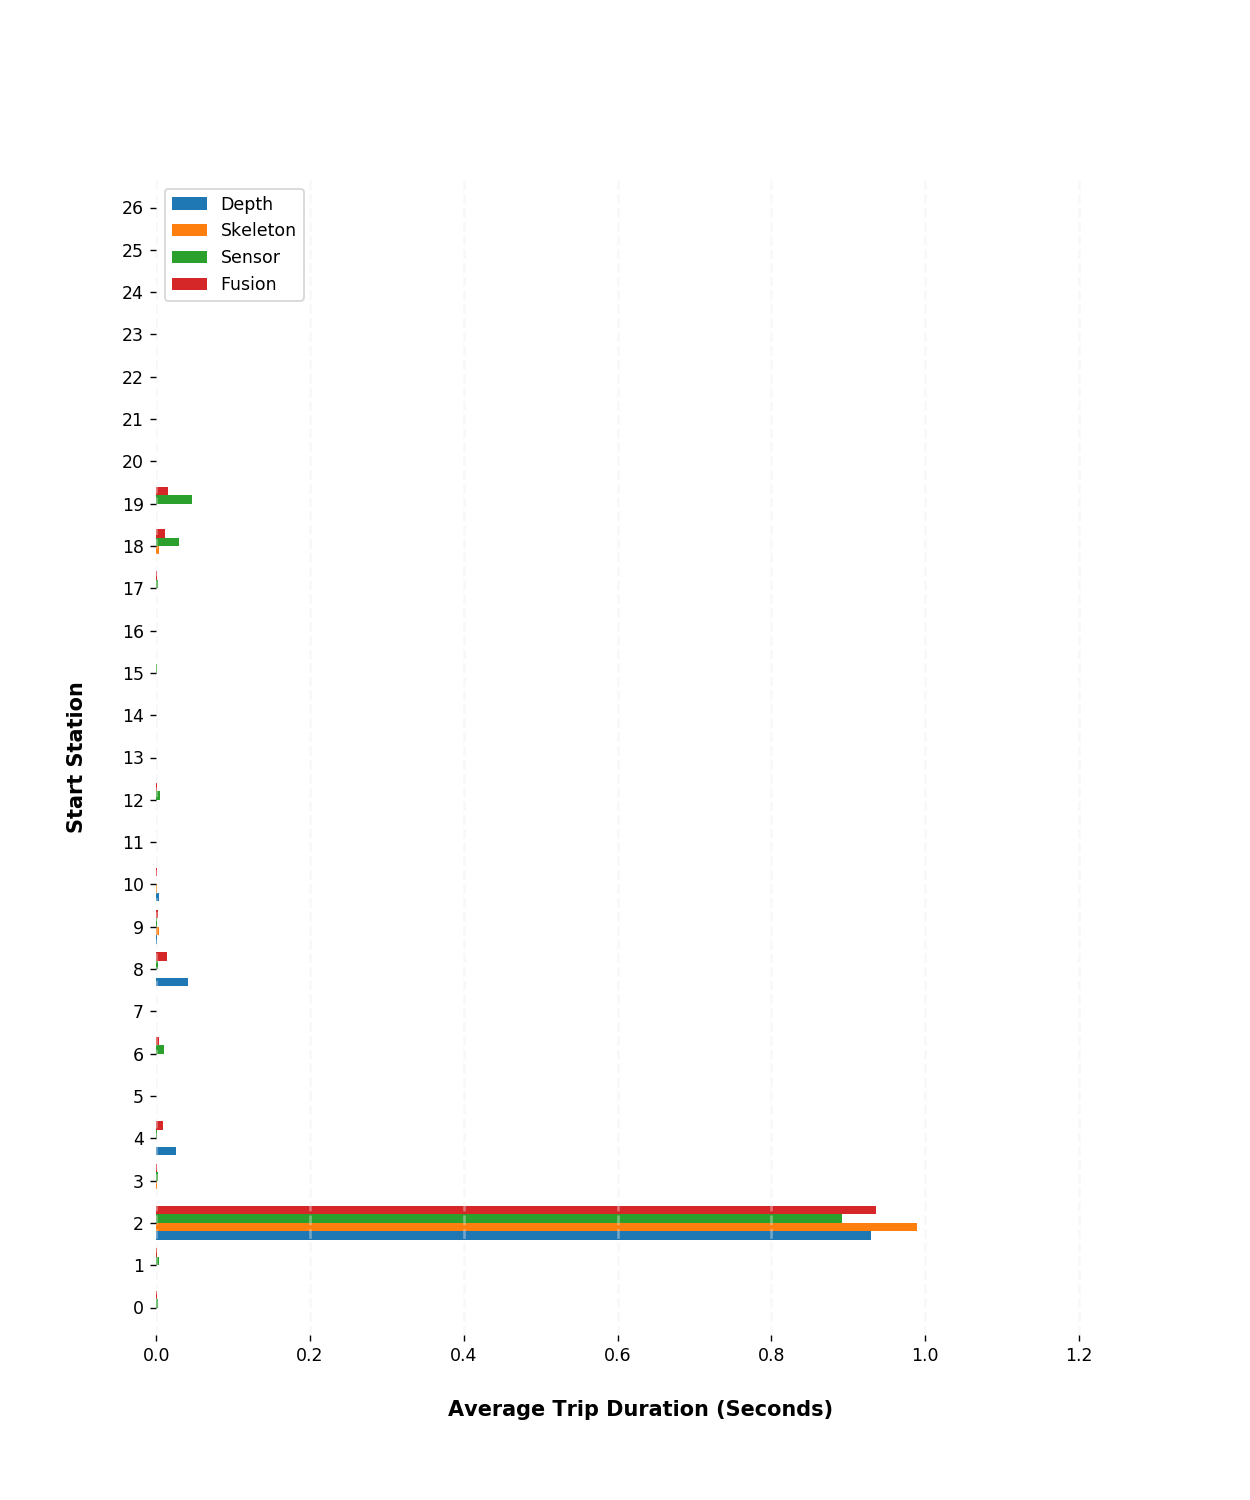

40 %
Loding complete


In [21]:
display(action)
display(subject)
display(sample)
display(button)
# Skeleton Values
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook

fig, ax = plt.subplots(nrows=4,ncols=2,figsize=(10,8))
gs = ax[0, 0].get_gridspec()
ax[0,0].remove()
ax[0,1].remove()
ax[1,0].remove()
ax[1,1].remove()
axbig = fig.add_subplot(gs[2, :])
axbig2 = fig.add_subplot(gs[3, :])
axim = fig.add_subplot(gs[0:2,0])
ax3D = fig.add_subplot(gs[0:2,1],projection='3d')
display(buttonfe)
figfe, axfe = plt.subplots(nrows=1,ncols=3,figsize=(10,5))
print('..............................')
print('Load Model')
display(toggle)
# print('..............................')
display(buttonpred)
display(op1)
display(op2)
display(op3)
display(op4)
figpre, axpre = plt.subplots(nrows=1,ncols=1,figsize=(10,12))

In [22]:
import pickle
f = open('results.pckl', 'rb')
accmat,recmat,premat= pickle.load(f)
f.close()

<IPython.core.display.Javascript object>


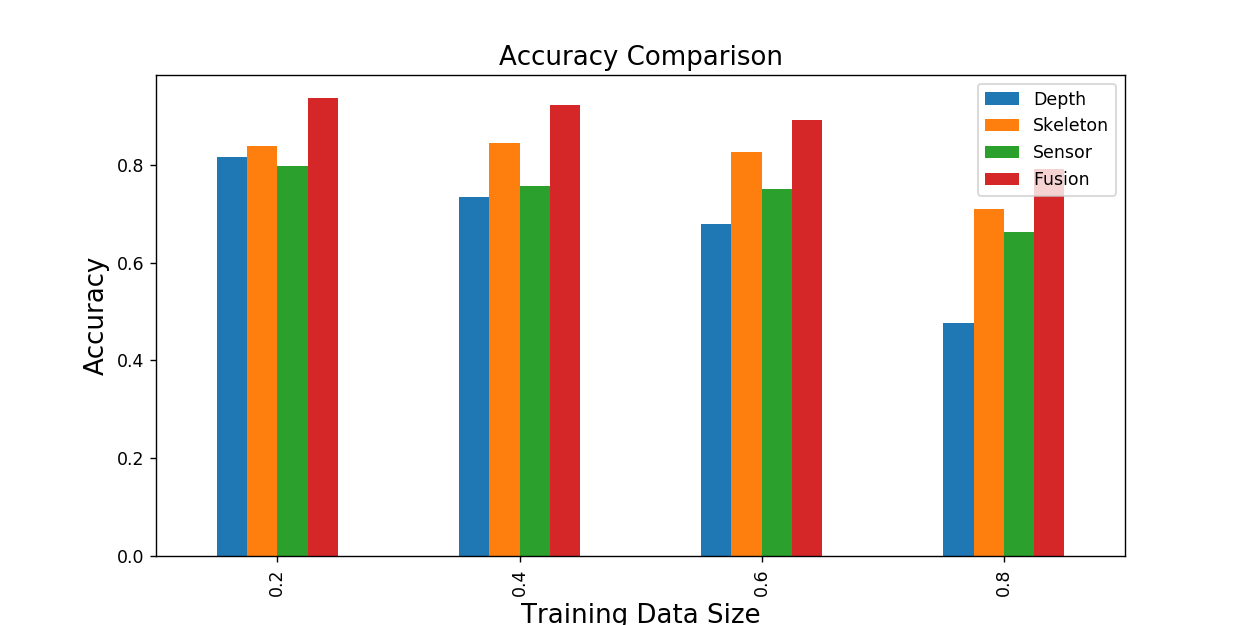

Text(0.5, 1.0, 'Accuracy Comparison')

In [23]:
accdf = pd.DataFrame(accmat,columns=['Depth','Skeleton','Sensor','Fusion'],index=['0.2','0.4','0.6','0.8'])
accdf.plot(kind='bar',figsize=(10,5))
plt.xlabel('Training Data Size',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.title('Accuracy Comparison',fontsize = 15)

<IPython.core.display.Javascript object>


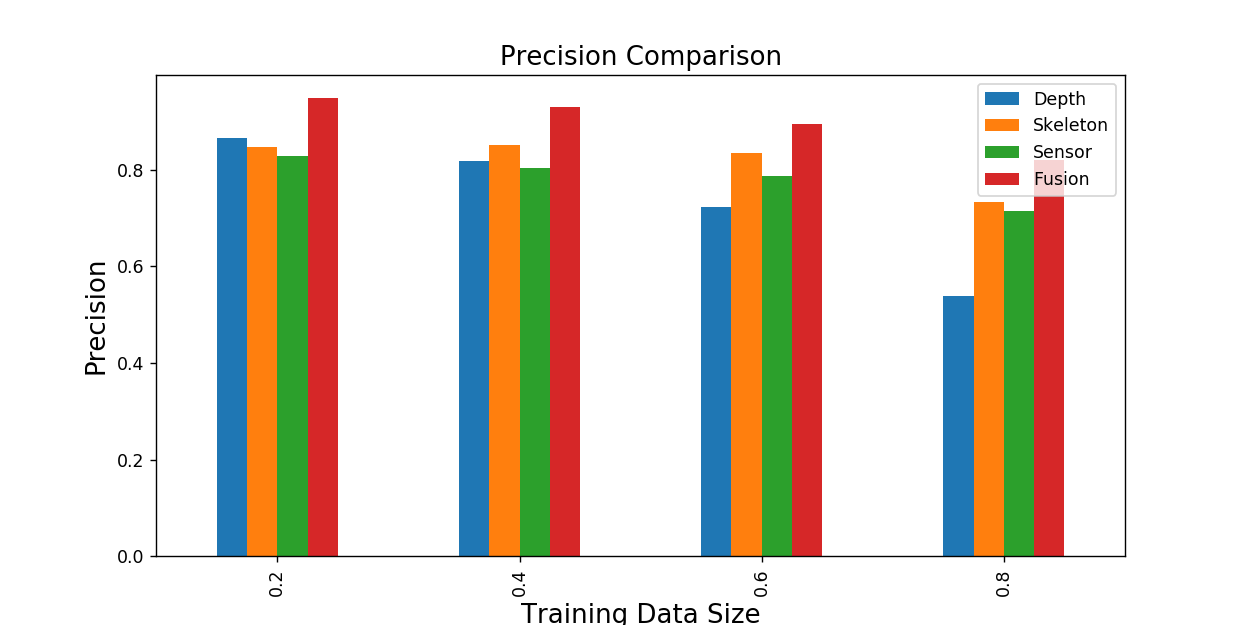

Text(0.5, 1.0, 'Precision Comparison')

In [23]:
predf = pd.DataFrame(premat,columns=['Depth','Skeleton','Sensor','Fusion'],index=['0.2','0.4','0.6','0.8'])
predf.plot(kind='bar',figsize=(10,5))
plt.xlabel('Training Data Size',fontsize=15)
plt.ylabel('Precision',fontsize=15)
plt.title('Precision Comparison',fontsize = 15)

<IPython.core.display.Javascript object>


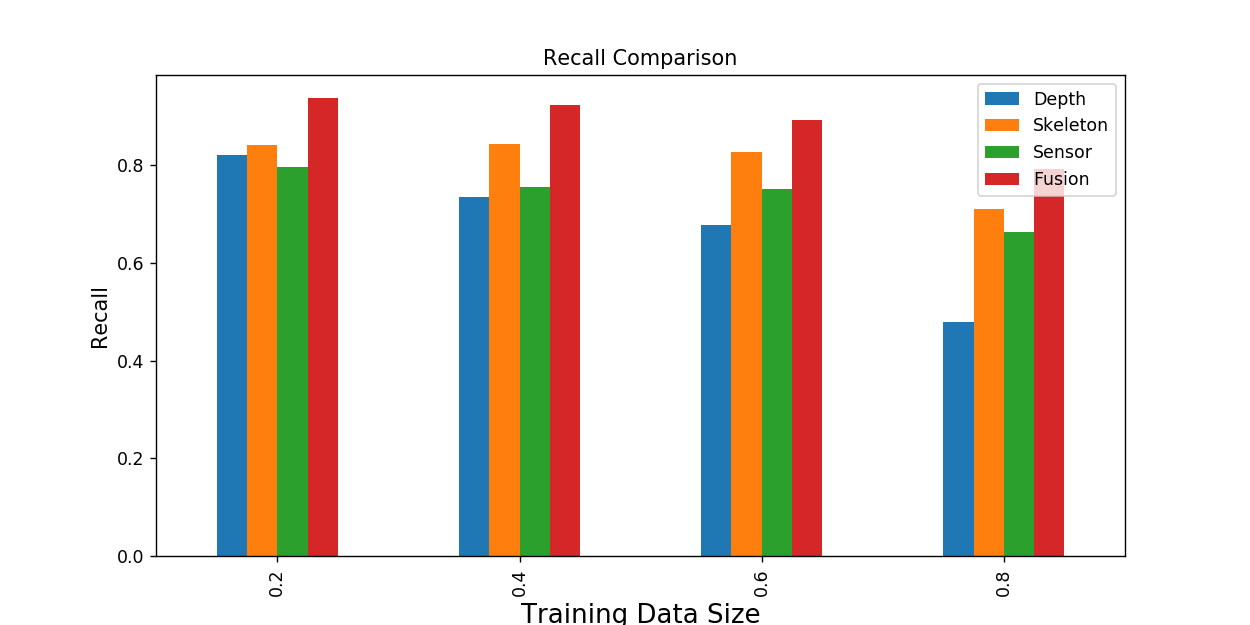

Text(0.5, 1.0, 'Recall Comparison')

In [25]:
recdf = pd.DataFrame(recmat,columns=['Depth','Skeleton','Sensor','Fusion'],index=['0.2','0.4','0.6','0.8'])
recdf.plot(kind='bar',figsize=(10,5))
plt.xlabel('Training Data Size',fontsize=15)
plt.ylabel('Recall',fontsize=12)
plt.title('Recall Comparison',fontsize = 12)